# Analyze Cibersort Fractions Matrix as if it was the output of a multi classfication model
```
Andrew Davidson
aedavids@ucsc.edu
```

each GTEx or TCGA sample was assumed to be a single type. e.g. Lung or LUAD

ref: notebook jan 14 2022
- createCibersortMixtureMatrix.ipynb
    - creates expected fractions matrix
- 12/10 page 100
- 12/13 page 103
- [one-hot-encoding-in-python-with-pandas-and-scikit-learn](https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/)
- [getting_column_label_of_max_value_in_each_row_in_pandas](https://www.skytowner.com/explore/getting_column_label_of_max_value_in_each_row_in_pandas_datafrme#:~:text=To%20get%20the%20column%20label,(axis%3D1)%20method.)
- [seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
- fractionsAsMulticlassClassificationPOC.ipynb
    - This notebook has a lot of debug code
 

## Results

<span style="color:red">I think there may be be some bugs sanityTest seems off</span> 

**cibersort preliminary results:**  

```
classes we did not make any predictions for: {'Artery_Tibial', 'Bladder'}
Artery_Tibial has 397 samples
Bladder has 9 samples

find true positivies
truePosDF.shape: (9590, 2)
true positive rate = 9590 / 15801 = 0.606923612429593

classes that do not have any true positives: {'Adipose_Visceral_Omentum'}
Adipose_Visceral_Omentum has 325 samples

if we filter results correlation > 0.9 and P-value <  0.01 we get a slight improvement in true positive rate

true positive rate : 6398 / 9877 = 0.6477675407512402

```
**cibersort-scalingBugFix results:**  

Based on scaWorkSpace/AndySandBox/juypterNotebook/normalizationSimulations.ipynb, I though we needed to
divide by scaling factors not multiple. It appears our results are much worse!

<span style="color:red">prelimary confusion matrix based on all 15,801 training set samples. We should filter and only check ones with correlations > 0.9</span>

```
***** WARNING for 11 classes we did not make any predictions:
 {'Esophagus_Gastroesophageal_Junction', 'Bladder', 'Brain_Caudate_basal_ganglia', 'Artery_Aorta', 'Brain_Cerebellum', 'Uterus', 'Artery_Coronary', 'Brain_Cortex', 'Artery_Tibial', 'Colon_Sigmoid', 'Cells_Cultured_fibroblasts'}


Esophagus_Gastroesophageal_Junction has 			 225 samples
Bladder has 			 9 samples
Brain_Caudate_basal_ganglia has 			 148 samples
Artery_Aorta has 			 259 samples
Brain_Cerebellum has 			 144 samples
Uterus has 			 85 samples
Artery_Coronary has 			 144 samples
Brain_Cortex has 			 153 samples
Artery_Tibial has 			 397 samples
Colon_Sigmoid has 			 224 samples
Cells_Cultured_fibroblasts has 			 302 samples

find true positivies
truePosDF.shape: (8662, 2)

******* WARNING there are 11 classes that do not have any true positives:
{'Esophagus_Gastroesophageal_Junction', 'Brain_Caudate_basal_ganglia', 'Cervix_Endocervix', 'Artery_Aorta', 'Brain_Cerebellum', 'Uterus', 'Artery_Coronary', 'Brain_Cortex', 'Esophagus_Muscularis', 'Colon_Sigmoid', 'Cells_Cultured_fibroblasts'}

Esophagus_Gastroesophageal_Junction has 225 samples
Brain_Caudate_basal_ganglia has 148 samples
Cervix_Endocervix has 6 samples
Artery_Aorta has 259 samples
Brain_Cerebellum has 144 samples
Uterus has 85 samples
Artery_Coronary has 144 samples
Brain_Cortex has 153 samples
Esophagus_Muscularis has 309 samples
Colon_Sigmoid has 224 samples
Cells_Cultured_fibroblasts has 302 samples

missingClassesSet - noTPSet         : {'Artery_Tibial', 'Bladder'}
missingClassesSet intersect noTPSet : {'Esophagus_Gastroesophageal_Junction', 'Brain_Caudate_basal_ganglia', 'Artery_Aorta', 'Brain_Cerebellum', 'Uterus', 'Artery_Coronary', 'Brain_Cortex', 'Colon_Sigmoid', 'Cells_Cultured_fibroblasts'}
noTPSet - missingClassesSet         : {'Cervix_Endocervix', 'Esophagus_Muscularis'}
```

**filtered preliminary results**  

if we filter results correlation > 0.9 and P-value <  0.01 we get a slight improvement in true positive rate

true positive rate : 6398 / 9877 = 0.6477675407512402

**filtered cibersort-scalingBugFix**  

we drop about 2/3 of the samples. There are a lot of classes with only a small number of sample 

true positive rate : 3607 / 5056 = 0.7134098101265823

In [1]:
import bme263DataVis.utilities as utl
from IPython.display import display
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import numpy as np
import pathlib as pl
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# useful function for converting plot titles to strings
# https://stackoverflow.com/a/1007615/4586180
import re
def urlify(s):

    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)

    # Replace all runs of whitespace with a single dash
    s = re.sub(r"\s+", '-', s)

    return s

# Prints: I-cant-get-no-satisfaction"
#print(urlify("I can't get no satisfaction!"))

## Load exected fractions

In [2]:
rootDir = pl.Path('/private/groups/kimlab/GTEx_TCGA/')
# ciberSortOutputDirName = "ciberSort" # preliminary results
# ciberSortOutputDirName = "ciberSort-preliminaryResults"
ciberSortOutputDirName = "cibersort-scalingBugFix" 

# gsp : gene signature dir. contains signatures and mixtures
print("AEDWIP do not hard code best or design")
gspDir = 'geneSignatureProfiles/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/' + ciberSortOutputDirName
expectedFractionsFileName = 'GTEx_TCGA_TrainGroupby_expectedFractions.txt'
expectedFractionsPath = rootDir.joinpath(gspDir).joinpath(expectedFractionsFileName)
assert expectedFractionsPath.exists() , f'ERROR missing {expectedFractionsPath}'
print(expectedFractionsPath)

AEDWIP do not hard code best or design
/private/groups/kimlab/GTEx_TCGA/geneSignatureProfiles/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/cibersort-scalingBugFix/GTEx_TCGA_TrainGroupby_expectedFractions.txt


In [3]:
# use optionalImgOutputDirnameLabel
# enable us to run different filter/processing experiments on our cibersort results with out loosing original
# output image
optionalImgOutputDirnameLabel = ""
optionalImgOutputDirnameLabel = "Filtered"

imgOutDir = pl.Path("img/fractionsAsMulticlassClassificationPOC").joinpath(ciberSortOutputDirName + optionalImgOutputDirnameLabel)
imgOutDir.mkdir(parents=True, exist_ok=True)
print(imgOutDir)

img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered


## Load predicted fractions

In [4]:
# preliminary results
# we change the file path convetions to support multiple cibersort experiments
# ciberSortResultsFile = 'CIBERSORTx_GTEx_TCGA_TrainGroupby_mixture_Results.txt' # preliminary results
# ciberSortResultsFile = rootDir.joinpath('cibersort.out/GTEx_TCGA_TrainGroupby_mixture').joinpath(ciberSortResultsFile)

tt="cibersort.out/GTEx_TCGA_TrainGroupby_mixture/best/GTEx_TCGA_1vsAll-design_tilda__gender_plus_category-padj-0.001-lfc-2.0-n-25"
ciberSortResultsFile = rootDir.joinpath(tt).joinpath(ciberSortOutputDirName).joinpath("results.txt")
print(ciberSortResultsFile)
assert ciberSortResultsFile.exists() , f'ERROR missing {ciberSortResultsFile}'

/private/groups/kimlab/GTEx_TCGA/cibersort.out/GTEx_TCGA_TrainGroupby_mixture/best/GTEx_TCGA_1vsAll-design_tilda__gender_plus_category-padj-0.001-lfc-2.0-n-25/cibersort-scalingBugFix/results.txt


In [5]:
#
# load data
#
expectedFractionsDF = pd.read_csv(expectedFractionsPath, sep='\t', index_col='sample_id')
print( f"expectedFractionsDF.shape: {expectedFractionsDF.shape}" )

cibersortFractionsDF = pd.read_csv(ciberSortResultsFile, sep='\t', index_col='Mixture')
print( f"cibersortFractionsDF.shape: {cibersortFractionsDF.shape}" )

#
# use correlation to remove bad predictions
#
print(f'\nselect predictions with correlation > 0.9')
selectGoodPredictions = cibersortFractionsDF.loc[:, 'Correlation'] > 0.9
print(f'sum(selectGoodPredictions correlation > 0.9) {sum(selectGoodPredictions)}')
cibersortFractionsDF = cibersortFractionsDF.loc[selectGoodPredictions, :]
#print(f'cibersortFractionsDF.shape {cibersortFractionsDF.shape}')


expectedFractionsDF = expectedFractionsDF.loc[selectGoodPredictions, :]
#print(f'expectedFractionsDF.shape {expectedFractionsDF.shape}')

#
# use p-value to remove bad predictions
#
print(f'\nselect predictions with P-value < 0.01')
selectGoodPredictions = cibersortFractionsDF.loc[:, 'P-value'] < 0.01
print(f'sum(selectGoodPredictions P-value < 0.01) {sum(selectGoodPredictions)}')
cibersortFractionsDF = cibersortFractionsDF.loc[selectGoodPredictions, :]
#print(f'cibersortFractionsDF.shape {cibersortFractionsDF.shape}')

expectedFractionsDF = expectedFractionsDF.loc[selectGoodPredictions, :]
#print(f'expectedFractionsDF.shape {expectedFractionsDF.shape}')


#
# remove stat cols
#
statsCols = ['P-value', 'Correlation', 'RMSE' ]
predictionsDF = cibersortFractionsDF.loc[:, ~cibersortFractionsDF.columns.isin( statsCols)]
print( f"predictionsDF.shape: {predictionsDF.shape}" )

#
# treat predicition as if it was the output layer of a multiclassifier
# use hard max to call the class
#
byRow = 1

# weird we get a warning if we do not use a copy
xxxDF = predictionsDF.copy()
xxxDF['max'] = predictionsDF.copy().max(axis=byRow)
predictionsDF = xxxDF

#
# find the name of the class associated with the max value
# if 2 cols have same value, idxmax will return the first one. i.e. the sample category for the max fractional value
#
predictionsDF['predictedCat'] = predictionsDF.idxmax(axis=byRow)

confusionDF = predictionsDF.merge(right=expectedFractionsDF, how='inner', left_index=True, right_index=True)
# we have a lot of columns because both prediction and expected fractions have a col for each type
print( f"confusionDF.shape: {confusionDF.shape}" )

#confusionDF.loc[:, ['predictedCat', 'category']].head()

expectedFractionsDF.shape: (15801, 88)
cibersortFractionsDF.shape: (15801, 86)

select predictions with correlation > 0.9
sum(selectGoodPredictions correlation > 0.9) 5553

select predictions with P-value < 0.01
sum(selectGoodPredictions P-value < 0.01) 5032
predictionsDF.shape: (5032, 83)
confusionDF.shape: (5032, 173)


In [6]:
cfMatrix = confusion_matrix(confusionDF['category'], confusionDF['predictedCat'])
# print(type(cfMatrix))
print(cfMatrix.shape)
display(cfMatrix)

(75, 75)


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   8,   0, ...,   0,   0,   0],
       [  0,  10,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   1,   0,   0],
       [  0,   0,   0, ...,   0,  47,   0],
       [  0,   0,   0, ...,   0,   0, 321]])

In [7]:
def sanityTest(cfDF, cfMatrix):
    '''
    make sure the confusion matrix plot labels are correct by check true positives
    
    check for classes we did not make any predictions for and classess
    with out any true positives
    
    adjust for these error and compare true positive values to confirm plot labels
    are in correct order
    '''
    print(f'cfDF.shape: {cfDF.shape}')
    testDF = confusionDF.loc[:, ['category', 'predictedCat'] ]
    uniqueCategories = testDF['category'].unique()
    print(f'len(uniqueCategories): {len(uniqueCategories)}')
    
    uniquePredictedCat = testDF['predictedCat'].unique()
    print(f'len(uniquePredictedCat): {len(uniquePredictedCat)}')
    
    # check for class that we did not make any predictions for!
    missingClassesSet = set(uniqueCategories) - set(uniquePredictedCat)
    print(f'\n***** WARNING for {len(missingClassesSet)} classes we did not make any predictions:\n {missingClassesSet}\n\n')
    for category in missingClassesSet:
        selectRows = cfDF['category'] == category
        print(f'{category} has \t\t\t {cfDF.loc[selectRows,:].shape[0]} samples')

    # add fake TP predictions
    # 
    # fakeDF = pd.DataFrame( {
    #                         "category" : ['Artery_Tibial', 'Bladder'],
    #                         "predictedCat" : ['Artery_Tibial', 'Bladder']
    #                         } 
    #                         , index = ['fakeSample1', 'fakeSample2']
    #                 )

    fakeDF = pd.DataFrame( {
                            "category" : list(missingClassesSet),
                            "predictedCat" : list(missingClassesSet)
                            },
                            index = ['fakeSample' + str(i) for i in range(len(missingClassesSet))]
                         )
                                         
    print(f'*** AEDWP fakeDF:\n{fakeDF}')
    
    testDF = pd.concat( [testDF, fakeDF] )    

    # find true positivies
    selectRows = testDF['category'] == testDF['predictedCat']
    print(f'\nfind true positivies')
    
    truePosDF = testDF.loc[selectRows, ['category', 'predictedCat'] ]
    print(f'truePosDF.shape: {truePosDF.shape}') 
    print(f' \n********* true positive rate : {truePosDF.shape[0]} / {testDF.shape[0]} = {truePosDF.shape[0] / testDF.shape[0]}')
    
    truePosCountsDF = truePosDF.sort_values(by='category').groupby(by='category').count()
    
    # find class that do not have any true possitives
    truePosClassesSet = set( truePosCountsDF.index.to_list() )
    noTPSet = set(uniqueCategories) - truePosClassesSet
    print( f'\n******* WARNING there are {len(noTPSet)} classes that do not have any true positives:\n{noTPSet}\n' )
    for category in noTPSet:
        selectRows = cfDF['category'] == category
        print(f'{category} has {cfDF.loc[selectRows,:].shape[0]} samples')

    print("\n********** AEDWIP")
    print(f'missingClassesSet - noTPSet         : {missingClassesSet - noTPSet}')    
    print(f'missingClassesSet intersect noTPSet : {missingClassesSet.intersection(noTPSet)}')
    print(f'noTPSet - missingClassesSet         : {noTPSet - missingClassesSet}')    


    #
    # what does the test below prove?
    #

    return
    
    # add fake true positive
    fakeDF = pd.DataFrame( {
                            #"category" : [np.NaN],
                            "predictedCat" : [0] * len(noTPSet)
                            } 
                            , index = list(noTPSet)
                    )
    print(f'***** AEDWIP fakeDF 2 :\n{fakeDF}')
    truePosCountsDF = pd.concat( [truePosCountsDF, fakeDF] ).sort_index()# sort_values(by='predictedCat')
    print(f'**** truePosCountsDF.shape : {truePosCountsDF.shape} index : {truePosCountsDF.index}')

    print(f'\n**** cfMatrix.shape : {cfMatrix.shape} index : {cfMatrix.index}')

    cfMatrixTruePositiveNP = cfMatrix.diagonal()
    print(f'\ncfMatrixTruePositiveNP with fake samples:\n{cfMatrixTruePositiveNP}')
    
    print(f'\n truePosCountsDF with fake sample\n{truePosCountsDF.values.flatten()}')
    
    expectedDiff = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0]

    #expectedDiff = "aedwip"
    
    diff = truePosCountsDF.values.flatten() - cfMatrixTruePositiveNP
    np.testing.assert_array_equal(expectedDiff, diff)
    
    
def testSanityTest():
    sanityTest(confusionDF, cfMatrix)
    
testSanityTest()

cfDF.shape: (5032, 173)
len(uniqueCategories): 73
len(uniquePredictedCat): 51

***** WARNING for 24 classes we did not make any predictions:
 {'Artery_Tibial', 'Cervix_Endocervix', 'Adipose_Visceral_Omentum', 'SKCM', 'Brain_Cortex', 'Prostate', 'BLCA', 'Ovary', 'Esophagus_Muscularis', 'Cells_Cultured_fibroblasts', 'CHOL', 'Colon_Sigmoid', 'Cells_EBV-transformed_lymphocytes', 'Brain_Caudate_basal_ganglia', 'LUSC', 'Breast_Mammary_Tissue', 'Artery_Coronary', 'Brain_Hypothalamus', 'Esophagus_Gastroesophageal_Junction', 'ACC', 'BRCA', 'Small_Intestine_Terminal_Ileum', 'SARC', 'Artery_Aorta'}


Artery_Tibial has 			 24 samples
Cervix_Endocervix has 			 1 samples
Adipose_Visceral_Omentum has 			 24 samples
SKCM has 			 19 samples
Brain_Cortex has 			 22 samples
Prostate has 			 74 samples
BLCA has 			 33 samples
Ovary has 			 3 samples
Esophagus_Muscularis has 			 20 samples
Cells_Cultured_fibroblasts has 			 2 samples
CHOL has 			 1 samples
Colon_Sigmoid has 			 2 samples
Cells_EBV-transfor

In [8]:
def calculateRowPercentages(cm):
    '''
    divides each value in a row by the row totoal
    
    arguments:
        cm: a confusion matrix
        
    returns
        a numpy array with same shape as cm 
    '''
    byRows = 1
    rowMarginEquals1 = np.sum(cm, axis=byRows)
    #print(f"rowMarginEquals1\n{rowMarginEquals1}")
    #print(f"rowMarginEquals1.shape\n{rowMarginEquals1.shape}")

    rowMarginEquals1Reshape = rowMarginEquals1.reshape(rowMarginEquals1.shape[0], 1)
    #print(f"\n rowMarginEquals1Reshape\n{rowMarginEquals1Reshape}")

    ret = cm/rowMarginEquals1Reshape
    
    return ret
    
    
def testCalculateRowPercentages(cm):
    ret = calculateRowPercentages(cm)
    print(ret)
    
testCalculateRowPercentages( cfMatrix )

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.41666667 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.78333333 0.        ]
 [0.         0.         0.         ... 0.         0.         0.81679389]]


/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


In [9]:
def createHeatMapAnnotations( rowPercentages ):
    '''
    seaborn heatmap argument annot = True display the cfMatrix cell values.
    fmt='.2%' argument would display the number cell values with 2 decimal places
    
    our confustion matrix is large, and has a lot of zeros making it hard to visualy
    interpurt the data.
    
    retuns 
        a numpy array of string with the same dimensions as rowPercentages
        use this as the value for the argument annot, do not use fmt
    '''
    numRows = rowPercentages.shape[0]
    numCols = rowPercentages.shape[1]
    
    bufferList = [0] * numRows
    for i in range(numRows):        
        a = [""] * numCols 
        for j in range(numCols):
            d = rowPercentages[i,j]
            if d > 0.0:
                #s = '{:.2f}'.format(d)
                s = '{}%'.format( round(d * 100), digits=0) 
                a[j] = s
                
        aNP = np.array( a, dtype=str )#.reshape( (1,numCols) )
        bufferList[i] = aNP
        
    return np.array(bufferList, dtype=object) 
    
def testCreateHeatMapAnnotations():
    rowPercentages = calculateRowPercentages(cfMatrix)
    print(f'rowPercentages.shape: {rowPercentages.shape}')
    print(rowPercentages)
    ret = createHeatMapAnnotations( rowPercentages )
    print(f'ret.shape: {ret.shape}')
    print(ret)
    
testCreateHeatMapAnnotations()

rowPercentages.shape: (75, 75)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.41666667 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.78333333 0.        ]
 [0.         0.         0.         ... 0.         0.         0.81679389]]
ret.shape: (75, 75)
[['' '' '' ... '' '' '']
 ['' '80%' '' ... '' '' '']
 ['' '42%' '' ... '' '' '']
 ...
 ['' '' '' ... '100%' '' '']
 ['' '' '' ... '' '78%' '']
 ['' '' '' ... '' '' '82%']]


/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


In [10]:
def plotConfusionMatrix(confusionData, labels, annotations, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts=False):
    '''
    arguments
        confusionData, labels, 
        
        annotations
            string values to display in heat map cells, must have same shape as confusionData
        
        imgOutDir, title, pageWidthInInches, pageHeightInInches
        
        displayCounts:
            boolean: default = False
            if true fmt is set to '.0f', and annotations are not displayed
    '''
    
    plotUtils =  utl.MatPlotLibUtilities()
    fig = plt.figure( figsize=(pageWidthInInches, pageHeightInInches) )

    # correlation
    cbarPanelWidthInInches = 0.25 #0.5
    panelWidthInInches = pageWidthInInches - cbarPanelWidthInInches
    panelHeightInInches = pageHeightInInches 
    leftRelativeSize = 0
    bottomRelativeSize = 0
    panel = plotUtils.createPanel(fig, panelWidthInInches, panelHeightInInches, 
                                             leftRelativeSize, bottomRelativeSize)
    
    cbarPanelHeightInInches = panelHeightInInches - 2 #1
    cbarLeftRelativeSize = 0.99 #0.985 #0.975 # 0.95   # % of fig width
    cbarBottomRelativeSize = 0.08 #0.1 #0.125 #0.15 # 0.10 # % of fig height
    cbarPanel = plotUtils.createPanel(fig, cbarPanelWidthInInches, cbarPanelHeightInInches, 
                                             cbarLeftRelativeSize, cbarBottomRelativeSize)

    if (displayCounts):
        panel = sns.heatmap( confusionData 
                            , xticklabels = labels
                            , yticklabels = labels
                            , ax = panel
                            , cbar_ax = cbarPanel
                            , cmap = "Blues"
                            , annot = True # display the numeric values in confusionData
                            #, fmt='.2%' # use if annot = True # default is '.2g'
                            , fmt=".0f" # use to display true positive counts
                            , square=True
                            , linecolor = "black" # default is "white"
                            , linewidths = 1.0
                   )
    else:
        panel = sns.heatmap( confusionData 
                        , xticklabels = labels
                        , yticklabels = labels
                        , ax = panel
                        , cbar_ax = cbarPanel
                        , cmap = "Blues"
                        , annot = annotations
                        , fmt='' # required if our annotations are strings
                        , square=True
                        , linecolor = "black" # default is "white"
                        , linewidths = 1.0

               )        

    panel.set_title(title)
    panel.set_ylabel('Actual')
    panel.set_xlabel('Predicted')

    # https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html
    panel.set_xticklabels(panel.get_xticklabels(), rotation=45, horizontalalignment='right')

    imgFile = imgOutDir.joinpath( urlify(title) + ".png" )
    print(f"save: {imgFile}")
    plt.savefig( imgFile , bbox_inches='tight', dpi=600,  facecolor="white", transparent=True)

In [11]:
def plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start, end, displayCounts=False):
    pageWidthInInches  = 8
    pageHeightInInches = 8
    
    if displayCounts:
        confusionData = cfMatrix
        annot = None
    else :
        confusionData = calculateRowPercentages( cfMatrix )
        annotations = createHeatMapAnnotations( confusionData )
        annot = annotations[start:end, start:end]

    cfMatrixL = confusionData[start:end, start:end] # confusion_matrix is TP, FP counts we want percentages 
    labelsL = labels[start:end]
    plotConfusionMatrix(cfMatrixL, labelsL, annot, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts)

In [12]:
# we did not make any predictions for: {'Bladder', 'Artery_Tibial'}
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# labels: List of labels to index the matrix. This may be used to reorder or select a subset of labels.
# If None is given, those that appear at least once in y_true or y_pred are used in sorted order.
default = None
cfMatrix = confusion_matrix(confusionDF['category'], confusionDF['predictedCat'], labels=default)
# create labels from ground trueth else confusion matrix will labels will be off
labels = sorted( set( confusionDF['category'].to_list() ) )


# for each row display the TP and FP as a %
# ie. row margin should sum to one
confusionData = calculateRowPercentages( cfMatrix )
annotations = createHeatMapAnnotations( confusionData )

/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


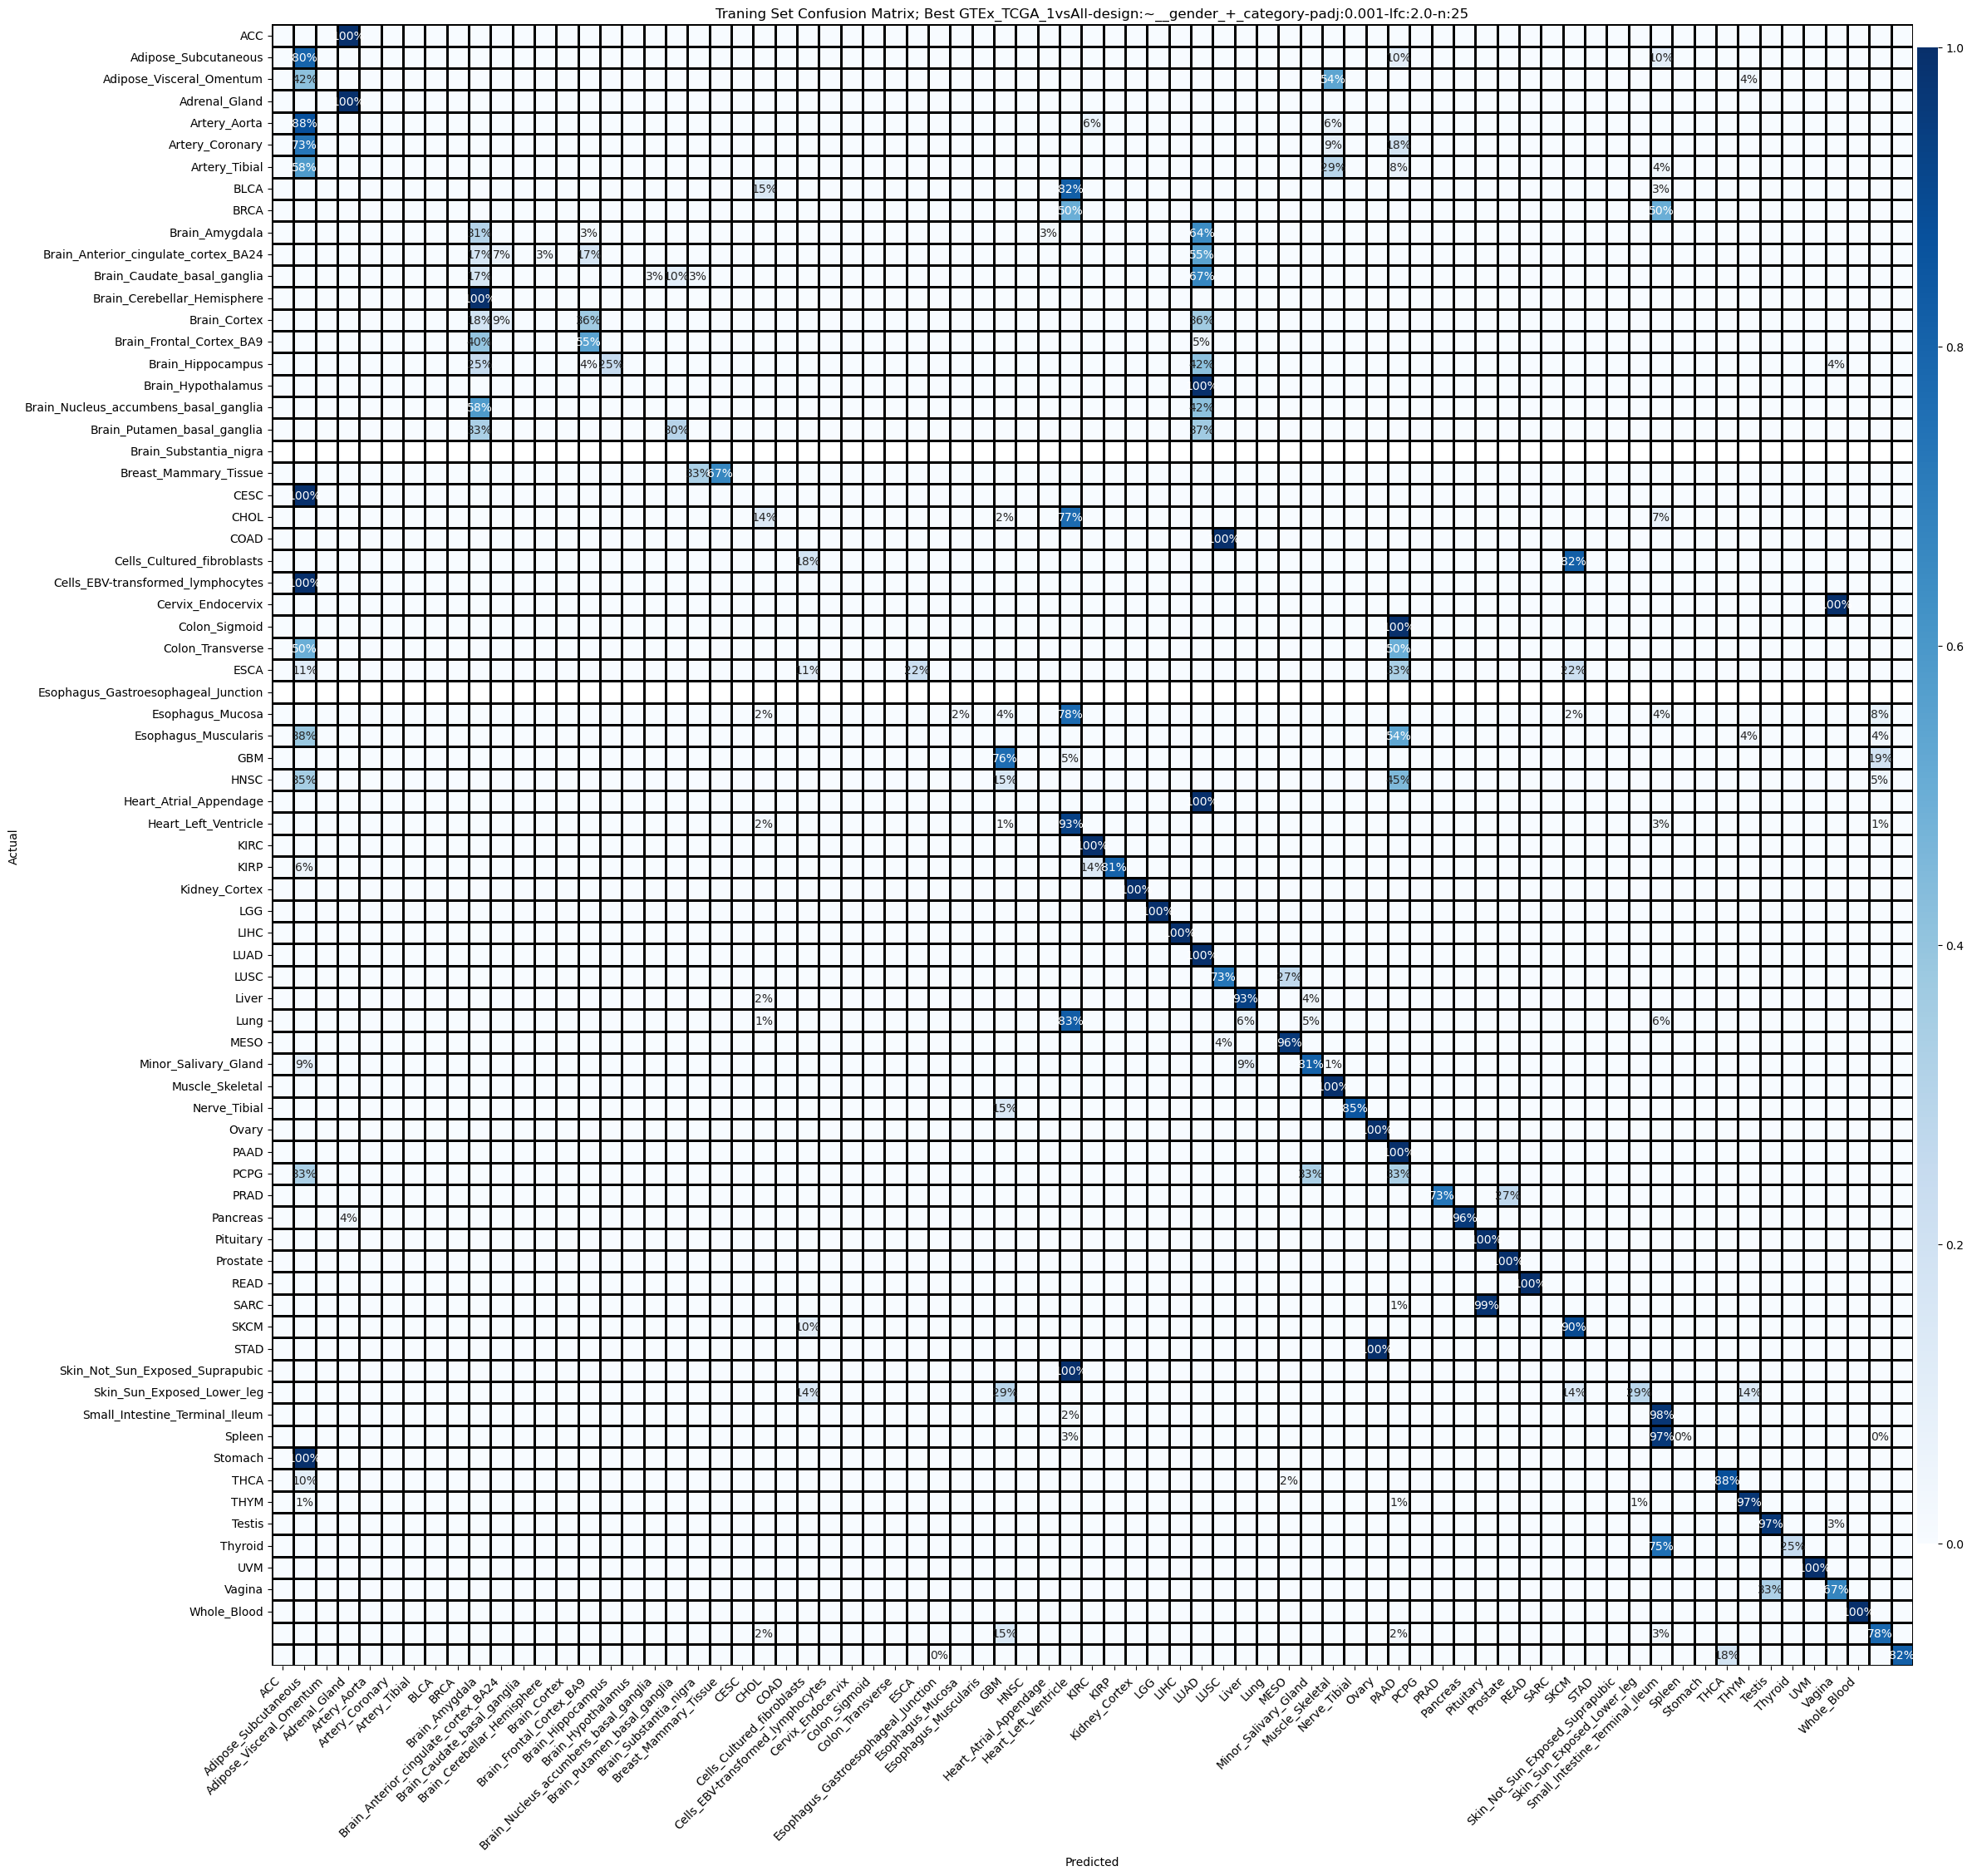

In [13]:
# plot the entire data set
title = "Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
pageWidthInInches  = 20 # 16 12 8
pageHeightInInches = 20 # 16,12 8

plotConfusionMatrix(confusionData, labels, annotations, imgOutDir, title, pageWidthInInches, pageHeightInInches)

/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p1-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


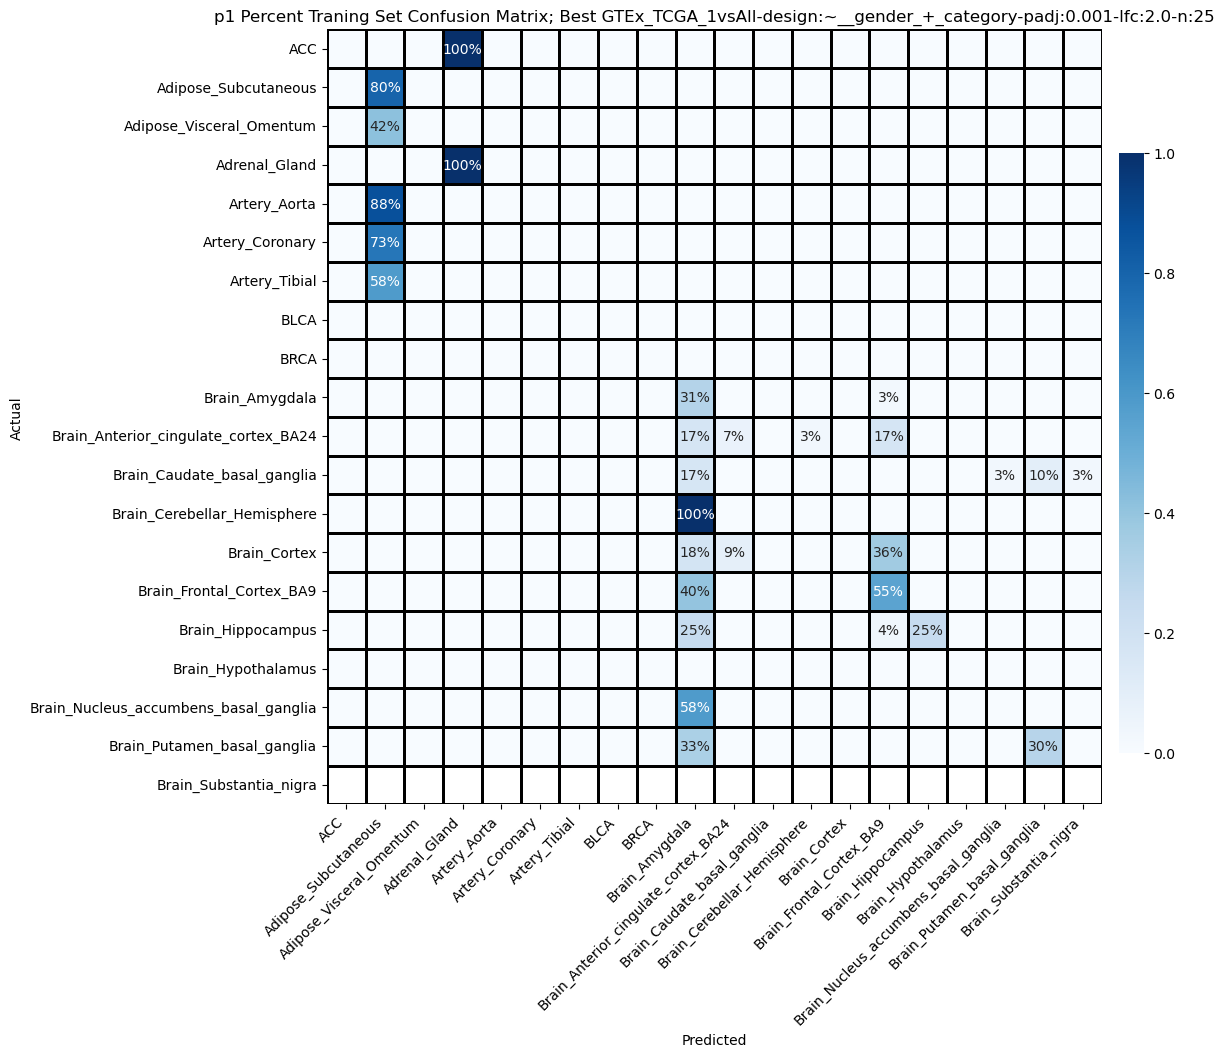

In [14]:
title = "p1 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=0, end=20, displayCounts=False)

save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p1-Counts-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


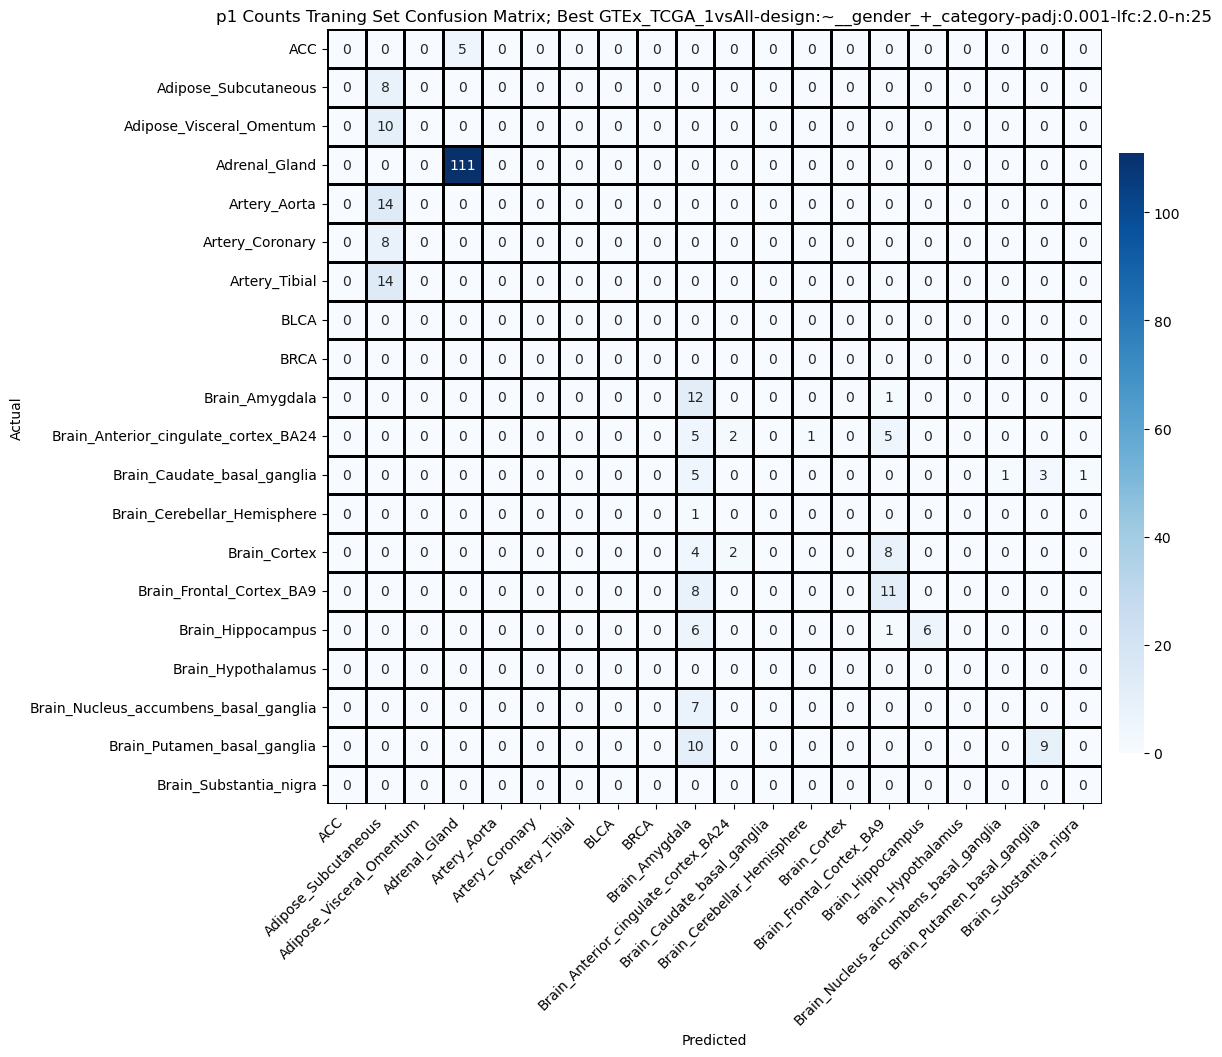

In [15]:
title = "p1 Counts Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=0, end=20, displayCounts=True)

/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p2-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


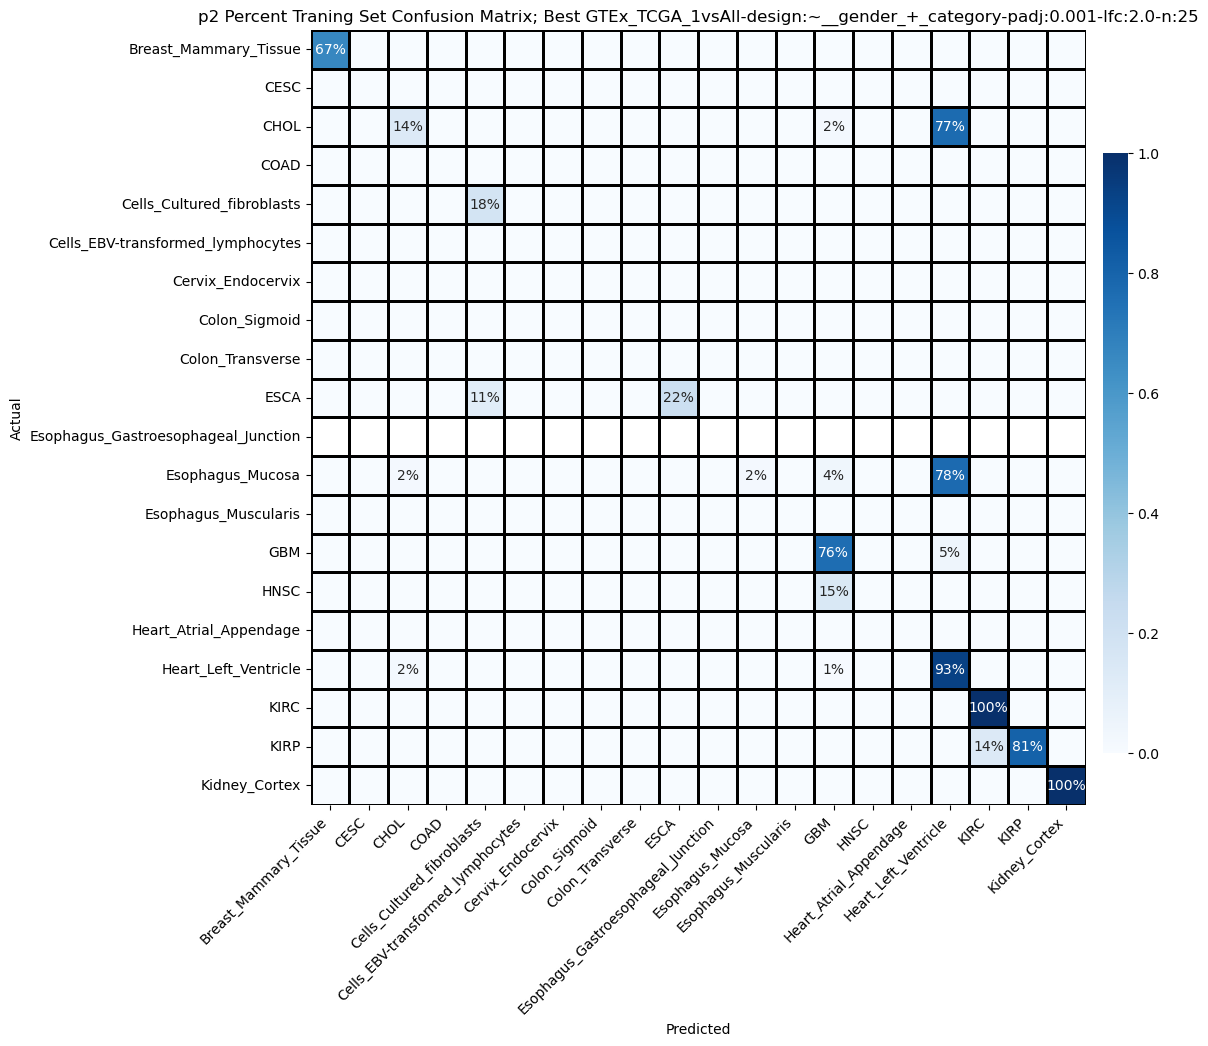

In [16]:
title = "p2 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=20, end=40, displayCounts=False)

/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p3-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


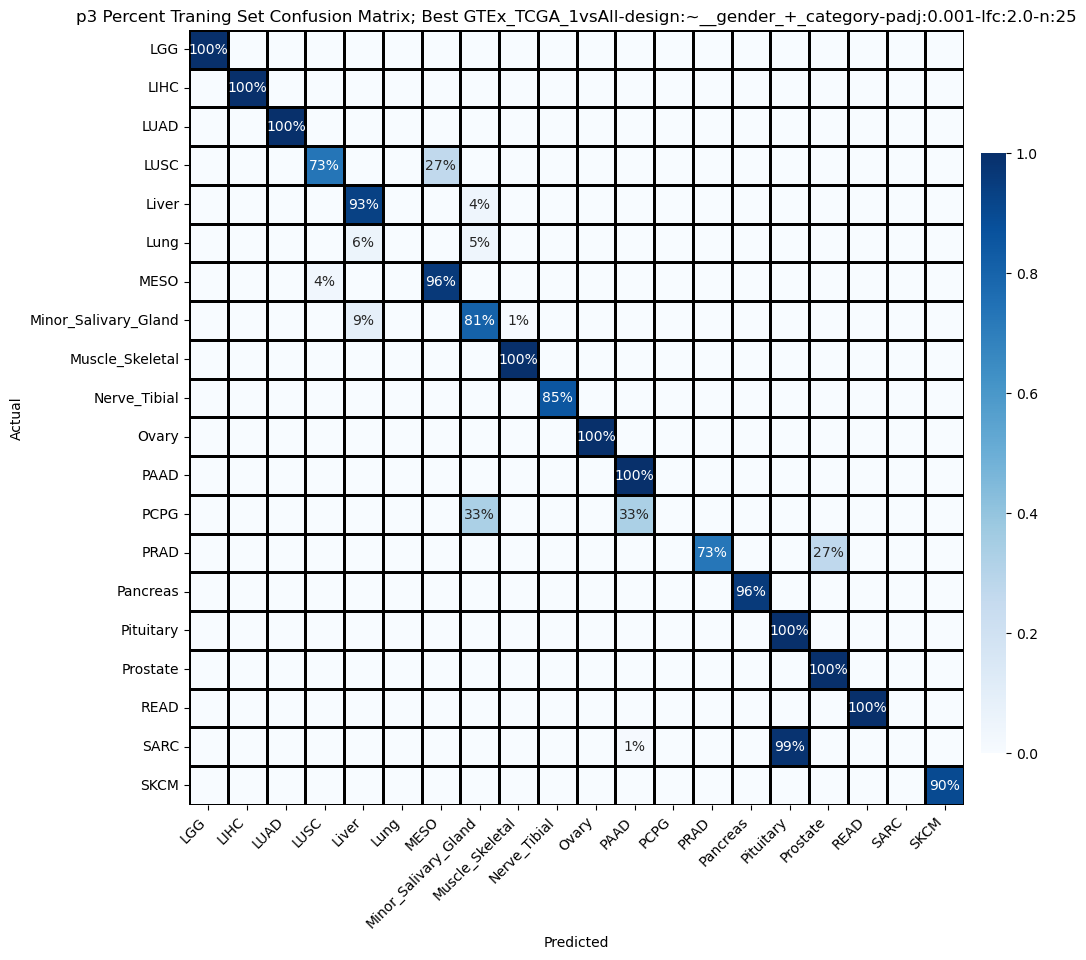

In [17]:
title = "p3 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=40, end=60)

save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p3-Count-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


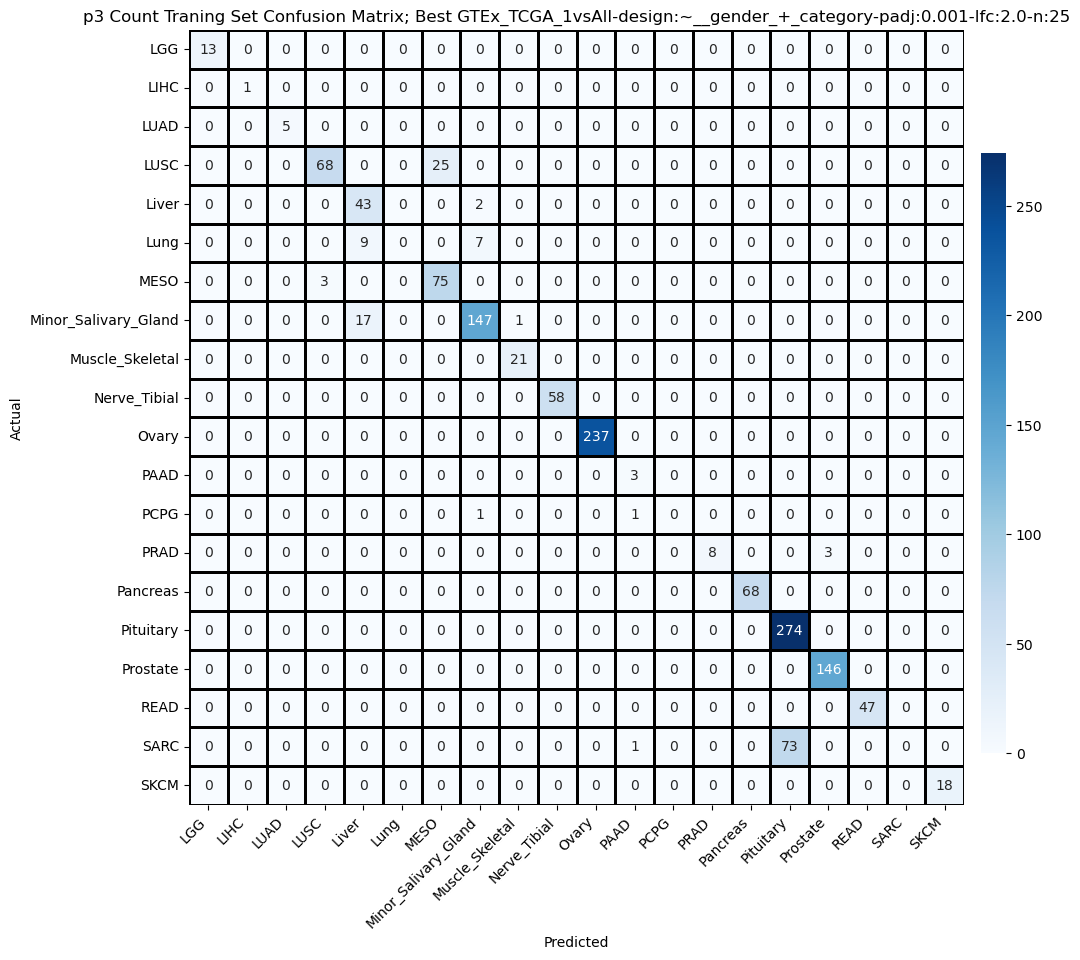

In [18]:
title = "p3 Count Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=40, end=60, displayCounts=True)

/data/tmp/ipykernel_3035789/378580651.py:19: RuntimeWarning: invalid value encountered in divide
  ret = cm/rowMarginEquals1Reshape


save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p4-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


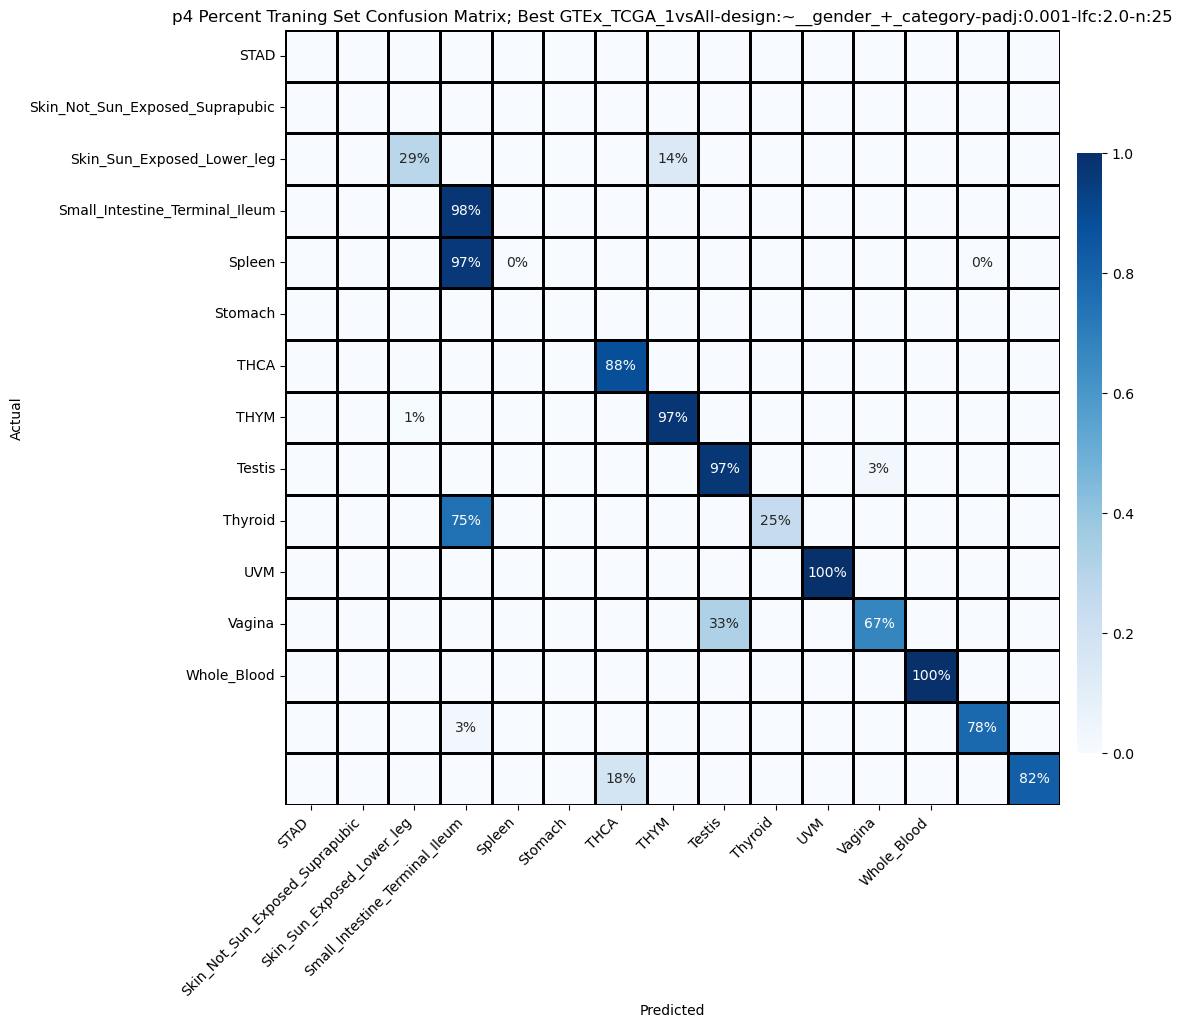

In [19]:
title = "p4 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=60, end=None)

save: img/fractionsAsMulticlassClassificationPOC/cibersort-scalingBugFixFiltered/p4-Counts-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


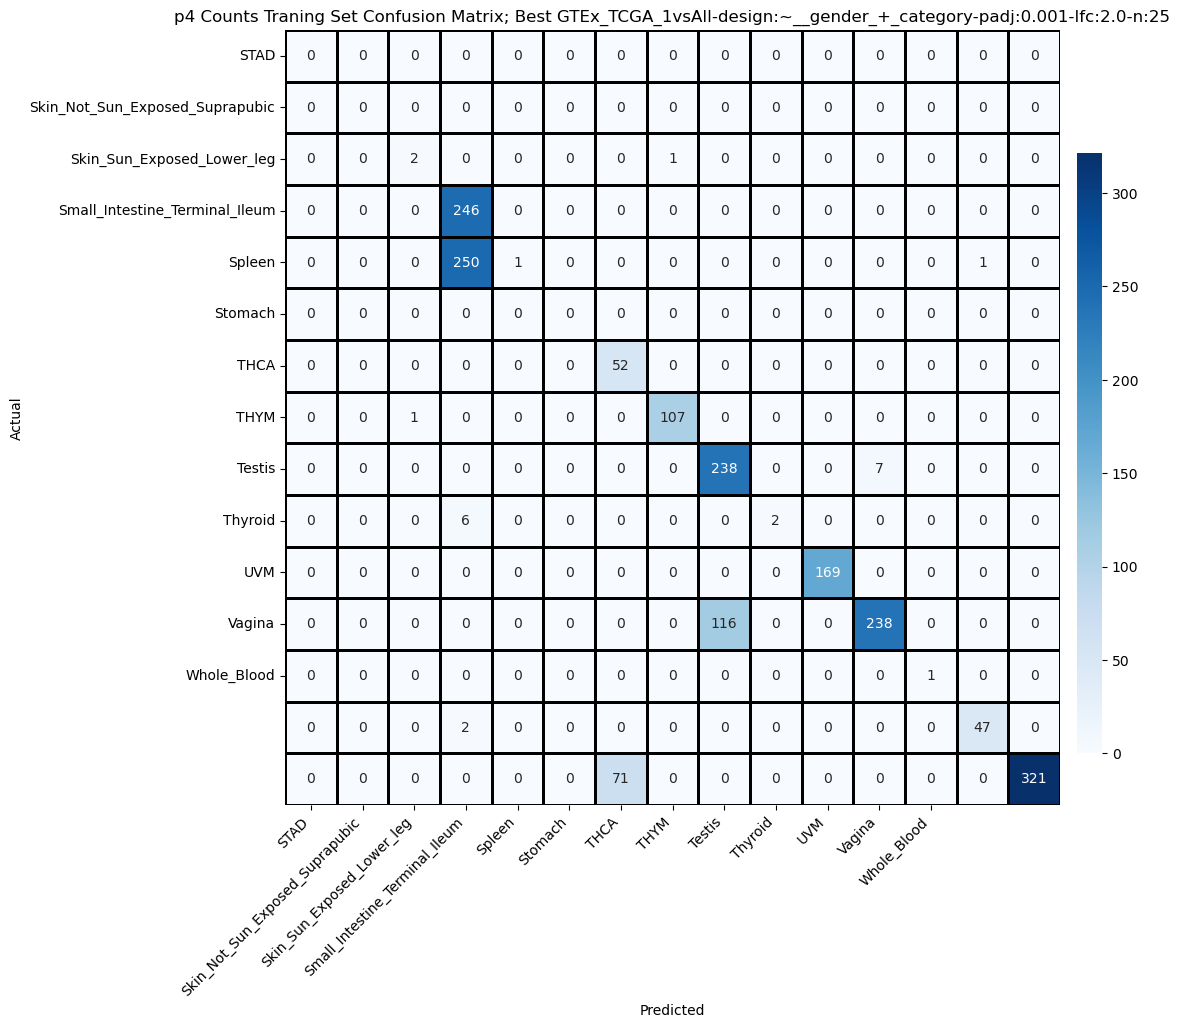

In [20]:
title = "p4 Counts Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=60, end=None, displayCounts=True)